In [126]:
# import libraries

import os
import torch
import itertools
import numpy as np
import pandas as pd
import torch.nn as nn
from torch import optim
import plotly.graph_objects as go
from matplotlib import pyplot as plt

In [127]:
# Functions

def clean(row, frame):
    if row.name != 0:
        
        Today_Open = frame["Open"][row.name]
        Yest_High = frame["High"][row.name-1]
        Yest_Low = frame["Low"][row.name-1]
        Yest_Close = frame["Close"][row.name-1]
        Yest_Volume = frame["Volume"][row.name-1]
        
        Yest_Open = frame["Open"][row.name-1]
        Today_Close = frame["Close"][row.name]
        
        if Yest_Close - Yest_Open >= 0:
            Yest_Price_Change = 1
        else:
            Yest_Price_Change = 0
            
        if Today_Close - Today_Open >= 0:
            Today_Price_Change = 1
        else:
            Today_Price_Change = 0
                      
        return Today_Open, Yest_High, Yest_Low, Yest_Close, Yest_Volume, Yest_Price_Change, Today_Price_Change
  
def s_ized(col):
    if col.name == "Price_Change_Yest" or col.name == "Price_Change_Today":
        new = col
    else:
       mean = np.mean(col)
       std = np.std(col)
       new = np.nan_to_num((col - mean) / std)

    return new


def loss_f(y_pred, y):
    return sum(y*(y_pred**.5) + ((1-y) * (1-y_pred)**.5)) / len(y_pred)

In [133]:
accuracys = []
images = []

for ct in range(3):
    for i in range(3):
        #Inputs
        number_of_companies = (ct+1)
        split_ratio = .70
        l_rate = .001

        nodes_layer_1 = 4
        nodes_layer_2 = 12
        nodes_layer_3 = 12
        nodes_layer_4 = 12
        nodes_layer_5 = 12

        # Load and Clean the Data
        arr = os.listdir('sample set')
        all_data = pd.DataFrame() 
        for file in arr[:number_of_companies]:
            file2 = open("sample set/" + file)
            data = pd.read_csv(file2)
            new_df = data.apply(clean, axis=1, frame = data, result_type = "broadcast")
            new_df2 = new_df.drop([0])
            all_data = all_data.append(new_df2)

        all_data = all_data.rename(columns={'Date': 'Open', 'Open': 'High', 'High':'Low', 'Low':'Close','Close':'Volume','Volume':'Price_Change_Yest', 'OpenInt':'Price_Change_Today'})
        all_data = all_data.apply(s_ized, axis=0)

        # more cleaning
        array = all_data.values
        Xs= array[:,:6]
        Y = array[:,6]

        Xs = Xs.tolist()
        Y = Y.tolist()

        Xs = torch.tensor(Xs)
        y = torch.tensor(Y)

        y = y.reshape(Xs.shape[0],1)

        # Split Data
        train_num = int(Xs.shape[0] * split_ratio)
        train_Xs = Xs[:train_num]
        test_Xs = Xs[train_num:]
        train_y = y[:train_num]
        test_y = y[train_num:]

        print(train_Xs.shape)

        # MLP Model Initialization


        # 3 Fully Connected and Sigmoid Network
        if i==0:
            model = torch.nn.Sequential(nn.Linear(6, nodes_layer_1),
                                        nn.Linear(nodes_layer_1, nodes_layer_2),
                                        nn.Linear(nodes_layer_2, 1),
                                        nn.Sigmoid())

            optimizer = torch.optim.Adam(model.parameters(), lr=l_rate)

        # 3 Fully Connected, 2 Relu's, and Sigmoid Network
        elif i==1: 
            model = torch.nn.Sequential(nn.Linear(6, nodes_layer_1),
                                        nn.ReLU(),
                                        nn.Linear(nodes_layer_1, nodes_layer_2),
                                        nn.ReLU(),
                                        nn.Linear(nodes_layer_2, 1),
                                        nn.Sigmoid())
            optimizer = torch.optim.Adam(model.parameters(), lr=l_rate)

        elif i ==2:
            model = torch.nn.Sequential(nn.Linear(6, nodes_layer_1),
                                        nn.ReLU(),
                                        nn.Linear(nodes_layer_1, nodes_layer_2),
                                        nn.ReLU(),
                                        nn.Linear(nodes_layer_2, nodes_layer_3),
                                        nn.ReLU(),
                                        nn.Linear(nodes_layer_3, nodes_layer_4),
                                        nn.ReLU(),
                                        nn.Linear(nodes_layer_4, nodes_layer_5),
                                        nn.ReLU(),
                                        nn.Linear(nodes_layer_5, 1),
                                        nn.Sigmoid())
        optimizer = torch.optim.Adam(model.parameters(), lr=l_rate)


        # Train Data
        Js = []
        epochs = []
        for i in range(200):
            # Forward
            y_predictions = model(train_Xs.float())

            # Objective func Loss
            loss = loss_f(y_predictions, train_y)

            # Calc gradients
            optimizer.zero_grad()
            loss.backward()

            # Update Weights
            optimizer.step()
            Js.append(loss)
            #print(loss)
            epochs.append(i)

        # Test Accuracy
        y_predictions = model(test_Xs.float())
        predictions = np.where(y_predictions > .5, 1, 0)
        accuracy = list(predictions-np.array(test_y)).count(0) / len(predictions-np.array(test_y))    
        accuracys.append(accuracy)
        images.append(Js)

torch.Size([11, 6])
torch.Size([11, 6])
torch.Size([11, 6])
torch.Size([2251, 6])
torch.Size([2251, 6])
torch.Size([2251, 6])
torch.Size([2579, 6])
torch.Size([2579, 6])
torch.Size([2579, 6])


1 Company
Accuracy for 3FCs folowed by Sigmoid 0.2
Accuracy for 2 FC_Relu's, followed by 1 FC_Sigmoid 0.6
Accuracy for 5 FC_Relu's followed by 1 FC_Sigmoid 0.4


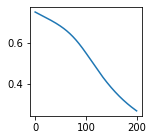

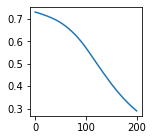

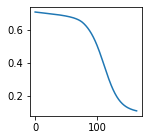

In [130]:
print("1 Company")

print("Accuracy for 3FCs folowed by Sigmoid", accuracys[0])
fig = plt.figure(figsize=(2,2))
graph = plt.plot(epochs, images[0])

print("Accuracy for 2 FC_Relu's, followed by 1 FC_Sigmoid", accuracys[1])
fig = plt.figure(figsize=(2,2))
graph = plt.plot(epochs, images[1])

print("Accuracy for 5 FC_Relu's followed by 1 FC_Sigmoid", accuracys[2])
fig = plt.figure(figsize=(2,2))
graph = plt.plot(epochs, images[2])

2 Companys
Accuracy for 3FCs folowed by Sigmoid 0.49222797927461137
Accuracy for 2 FC_Relu's, followed by 1 FC_Sigmoid 0.49222797927461137
Accuracy for 5 FC_Relu's followed by 1 FC_Sigmoid 0.49222797927461137


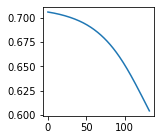

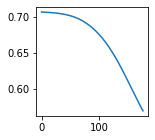

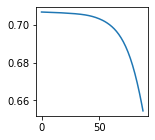

In [131]:
print("2 Companys")

print("Accuracy for 3FCs folowed by Sigmoid", accuracys[3])
fig = plt.figure(figsize=(2,2))
graph = plt.plot(epochs, images[3])

print("Accuracy for 2 FC_Relu's, followed by 1 FC_Sigmoid", accuracys[4])
fig = plt.figure(figsize=(2,2))
graph = plt.plot(epochs, images[4])

print("Accuracy for 5 FC_Relu's followed by 1 FC_Sigmoid", accuracys[5])
fig = plt.figure(figsize=(2,2))
graph = plt.plot(epochs, images[5])

3 Company
Accuracy for 3FCs folowed by Sigmoid 0.5244122965641953
Accuracy for 2 FC_Relu's, followed by 1 FC_Sigmoid 0.5244122965641953
Accuracy for 5 FC_Relu's followed by 1 FC_Sigmoid 0.5244122965641953


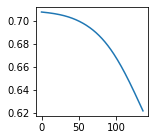

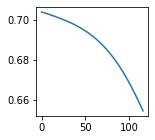

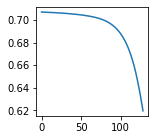

In [132]:
print("3 Company")

print("Accuracy for 3FCs folowed by Sigmoid", accuracys[6])
fig = plt.figure(figsize=(2,2))
graph = plt.plot(epochs, images[6])

print("Accuracy for 2 FC_Relu's, followed by 1 FC_Sigmoid", accuracys[7])
fig = plt.figure(figsize=(2,2))
graph = plt.plot(epochs, images[7])

print("Accuracy for 5 FC_Relu's followed by 1 FC_Sigmoid", accuracys[8])
fig = plt.figure(figsize=(2,2))
graph = plt.plot(epochs, images[8])